# 🧠 IndraQuantum Training Monitor (Rank 64)

**Generated:** 2025-12-07 06:49

This notebook visualizes the training dynamics of the Quantum-Inspired Student Model.
**Goal:** Achieve stable convergence with <1M parameters using Knowledge Distillation.


In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.optimize import curve_fit

# Configuration
log_file = "../logs/training_metrics_rank64_optimized.csv"
if not os.path.exists(log_file):
    print("Log file not found! Ensure training is running.")
else:
    df = pd.read_csv(log_file)
    # Fix column names if needed
    if "KD_Logits" in df.columns:
        df["KD_Loss"] = df["KD_Logits"]

    print(f"Loaded {len(df)} batch records")
    print(f"Current Epoch: {df['Epoch'].max()}")
    df.tail()

Loaded 14000 batch records
Current Epoch: 50


## 1. Epoch Oscillation Analysis

This plot visualizes the **Stability** of learning.

- **Line**: Average CE Loss (Accuracy)
- **Shaded Area**: Standard Deviation (Batch-to-Batch Noise)


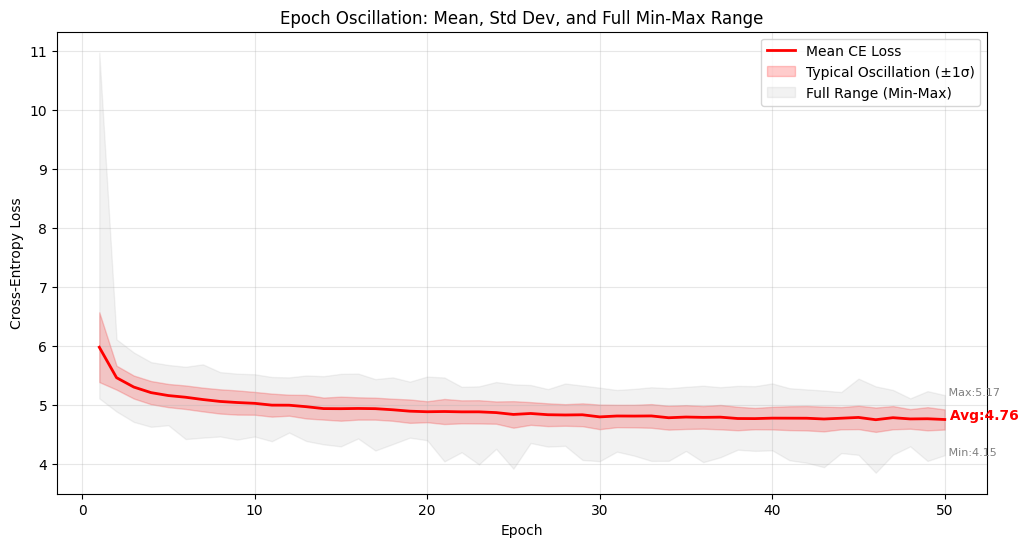

In [131]:
plt.figure(figsize=(12, 6))
# Calculate detailed stats
epoch_stats = df.groupby("Epoch")["CE_Loss"].agg(["mean", "std", "min", "max"])

# 1. Main Trend (Mean)
plt.plot(
    epoch_stats.index,
    epoch_stats["mean"],
    label="Mean CE Loss",
    color="red",
    linewidth=2,
)

# 2. Typical Oscillation (Standard Deviation)
plt.fill_between(
    epoch_stats.index,
    epoch_stats["mean"] - epoch_stats["std"],
    epoch_stats["mean"] + epoch_stats["std"],
    color="red",
    alpha=0.2,
    label="Typical Oscillation (±1σ)",
)

# 3. Extreme Oscillation (Min-Max Range)
plt.fill_between(
    epoch_stats.index,
    epoch_stats["min"],
    epoch_stats["max"],
    color="gray",
    alpha=0.1,
    label="Full Range (Min-Max)",
)

# Annotate current values
last_ep = epoch_stats.index[-1]
last_mean = epoch_stats["mean"].iloc[-1]
last_min = epoch_stats["min"].iloc[-1]
last_max = epoch_stats["max"].iloc[-1]

plt.text(last_ep, last_mean, f" Avg:{last_mean:.2f}", color="red", fontweight="bold")
plt.text(last_ep, last_max, f" Max:{last_max:.2f}", color="gray", fontsize=8)
plt.text(last_ep, last_min, f" Min:{last_min:.2f}", color="gray", fontsize=8)

plt.title("Epoch Oscillation: Mean, Std Dev, and Full Min-Max Range")
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy Loss")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

## 2. Advanced Multi-Metric Analysis

- **Perplexity ($e^{CE}$)**: The "Surprise Factor". Lower is better.
- **Relative Rate**: Improvements relative to start.
- **3D Trajectory**: (Epoch, CE, KD) optimization path.
- **Velocity**: Rate of change per epoch.


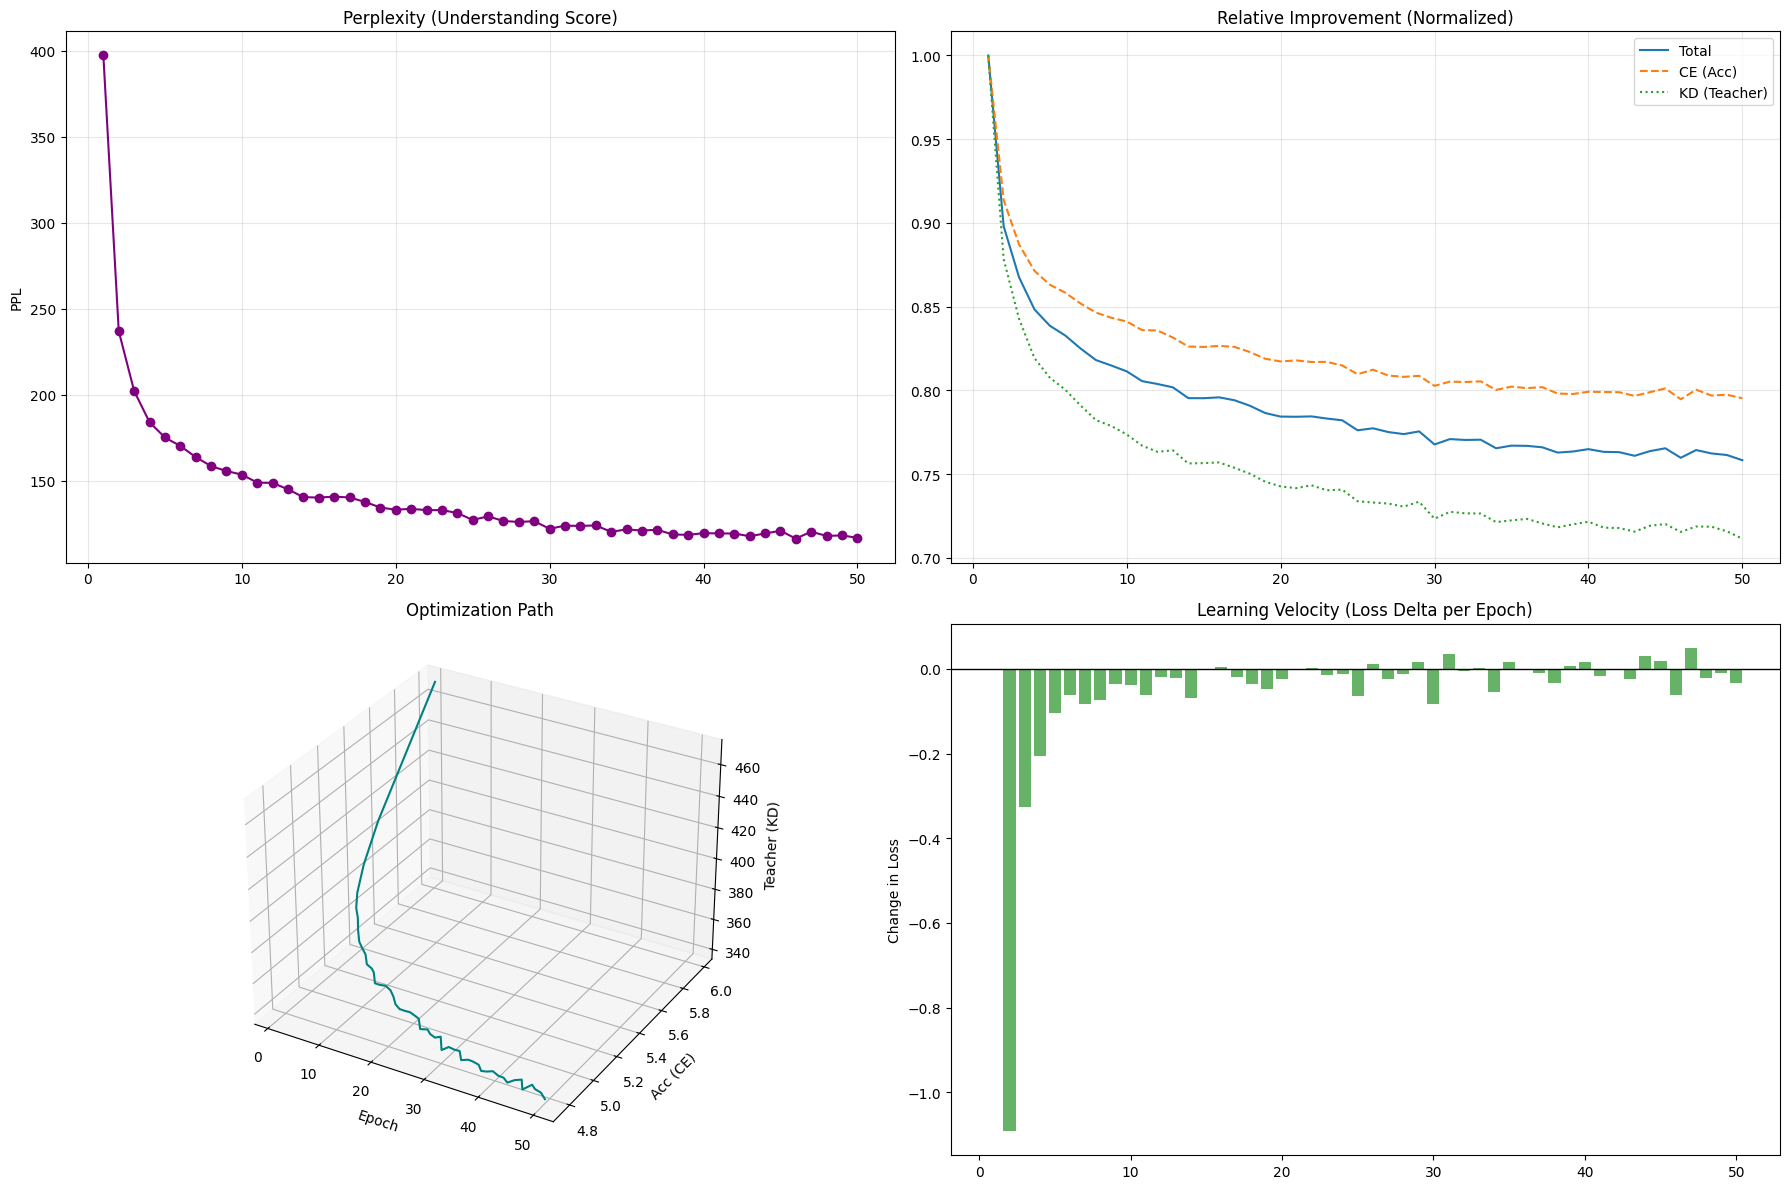

In [132]:
fig = plt.figure(figsize=(18, 12))
epoch_mean = df.groupby("Epoch").mean()

# A. Perplexity
ax1 = fig.add_subplot(2, 2, 1)
ppl = np.exp(epoch_mean["CE_Loss"])
ax1.plot(ppl.index, ppl, color="purple", marker="o")
ax1.set_title("Perplexity (Understanding Score)")
ax1.set_ylabel("PPL")
ax1.grid(True, alpha=0.3)

# B. Relative Improvement
ax2 = fig.add_subplot(2, 2, 2)
ax2.plot(
    epoch_mean.index,
    epoch_mean["Total_Loss"] / epoch_mean["Total_Loss"].iloc[0],
    label="Total",
)
ax2.plot(
    epoch_mean.index,
    epoch_mean["CE_Loss"] / epoch_mean["CE_Loss"].iloc[0],
    label="CE (Acc)",
    linestyle="--",
)
ax2.plot(
    epoch_mean.index,
    epoch_mean["KD_Loss"] / epoch_mean["KD_Loss"].iloc[0],
    label="KD (Teacher)",
    linestyle=":",
)
ax2.set_title("Relative Improvement (Normalized)")
ax2.legend()
ax2.grid(True, alpha=0.3)

# C. 3D Trajectory
ax3 = fig.add_subplot(2, 2, 3, projection="3d")
ax3.plot(epoch_mean.index, epoch_mean["CE_Loss"], epoch_mean["KD_Loss"], color="teal")
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Acc (CE)")
ax3.set_zlabel("Teacher (KD)")
ax3.set_title("Optimization Path")

# D. Learning Rate Efficiency
ax4 = fig.add_subplot(2, 2, 4)
loss_diff = epoch_mean["Total_Loss"].diff().fillna(0)
ax4.bar(loss_diff.index, loss_diff, color="green", alpha=0.6)
ax4.set_title("Learning Velocity (Loss Delta per Epoch)")
ax4.set_ylabel("Change in Loss")
ax4.axhline(0, color="black", linewidth=1)

plt.tight_layout()
plt.show()

## 3. Convergence Projection

- **Target CE (Safe Goal)**: 4.0 (Typical for <1M params)
- **Target CE (Stretch Goal)**: 3.5 (Fluent English)

We estimate the **Expected Completion Epoch** based on the current learning speed (last 5 epochs).


Current CE: 4.7596
Target CE: 4.0
Distance to Target: 0.7596
Current Velocity: -0.0016 loss/epoch
ESTIMATED COMPLETION: Epoch 521


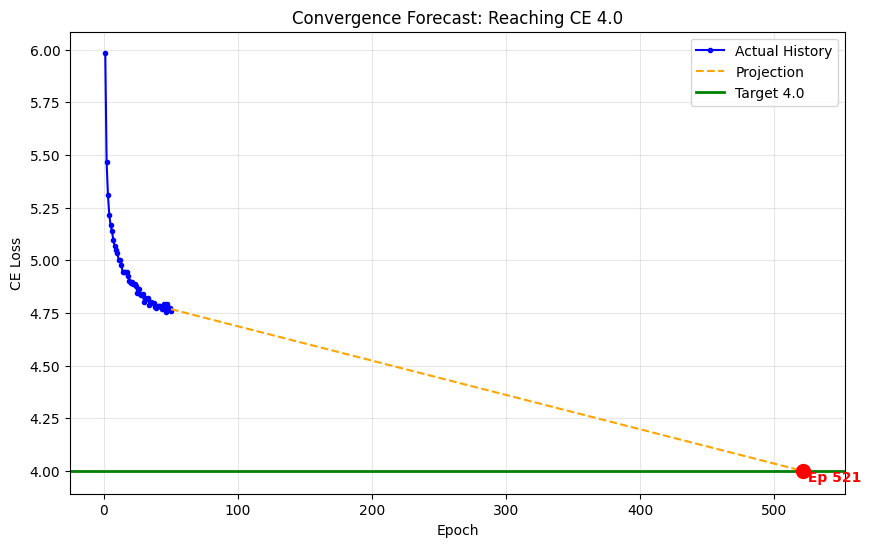

In [133]:
TARGET_CE = 4.0
recent_window = 10  # Use trend of last 10 epochs

ce_history = df.groupby("Epoch")["CE_Loss"].mean()

if len(ce_history) > recent_window:
    # Linear fit prediction
    y_recent = ce_history.iloc[-recent_window:]
    x_recent = y_recent.index

    coef = np.polyfit(x_recent, y_recent, 1)
    slope = coef[0]
    intercept = coef[1]

    current_ce = ce_history.iloc[-1]
    dist_to_target = current_ce - TARGET_CE

    print(f"Current CE: {current_ce:.4f}")
    print(f"Target CE: {TARGET_CE}")
    print(f"Distance to Target: {dist_to_target:.4f}")
    print(f"Current Velocity: {slope:.4f} loss/epoch")

    if slope < 0 and dist_to_target > 0:
        target_epoch = (TARGET_CE - intercept) / slope
        print(f"ESTIMATED COMPLETION: Epoch {int(target_epoch)}")

        plt.figure(figsize=(10, 6))
        plt.plot(
            ce_history.index,
            ce_history,
            label="Actual History",
            marker=".",
            color="blue",
        )

        fut_x = np.linspace(ce_history.index[-1], target_epoch + 5, 20)
        fut_y = slope * fut_x + intercept
        plt.plot(fut_x, fut_y, label="Projection", linestyle="--", color="orange")

        plt.axhline(TARGET_CE, color="green", label="Target 4.0", linewidth=2)
        plt.scatter([target_epoch], [TARGET_CE], color="red", s=100, zorder=5)
        plt.text(
            target_epoch,
            TARGET_CE - 0.05,
            f" Ep {int(target_epoch)}",
            color="red",
            fontweight="bold",
        )

        plt.title(f"Convergence Forecast: Reaching CE {TARGET_CE}")
        plt.xlabel("Epoch")
        plt.ylabel("CE Loss")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
    else:
        print("Model is not converging linearly or already passed target.")
else:
    print("Need more data for projection.")

## 3. Phase 2 (Stage 1) Pre-training Analysis

Monitoring the initial pre-training loss on WikiText.


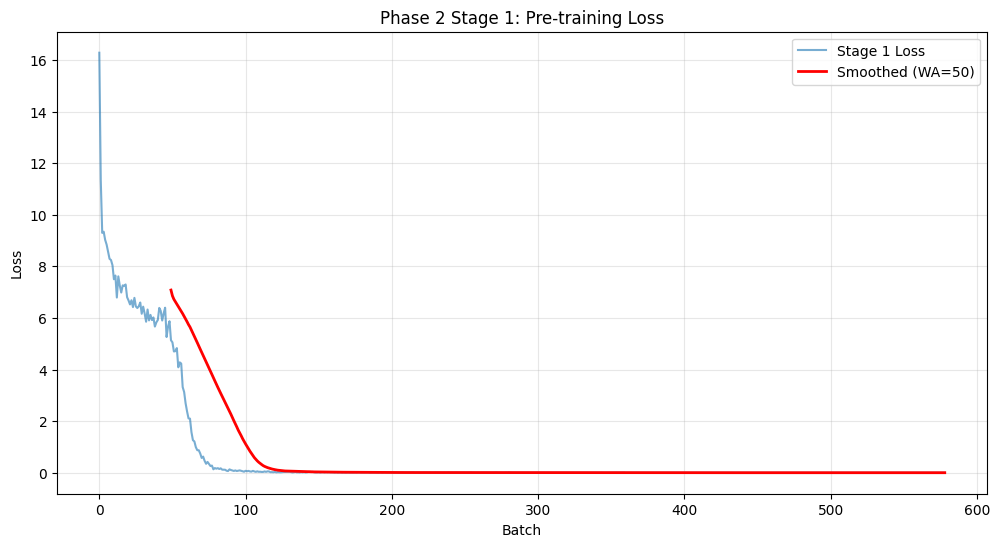

In [134]:
# Load Stage 1 Data
log_file_s1 = "../logs/training_metrics_stage1.csv"
if os.path.exists(log_file_s1):
    df_s1 = pd.read_csv(log_file_s1)
    plt.figure(figsize=(12, 6))
    plt.plot(df_s1["Loss"], label="Stage 1 Loss", alpha=0.6)
    plt.plot(
        df_s1["Loss"].rolling(50).mean(),
        label="Smoothed (WA=50)",
        color="red",
        linewidth=2,
    )
    plt.title("Phase 2 Stage 1: Pre-training Loss")
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("Stage 1 log not found.")

## 4. Phase 2 (Stage 2) Semantic Distillation Analysis

Monitoring the Semantic Distillation process comparing Student and Teacher.


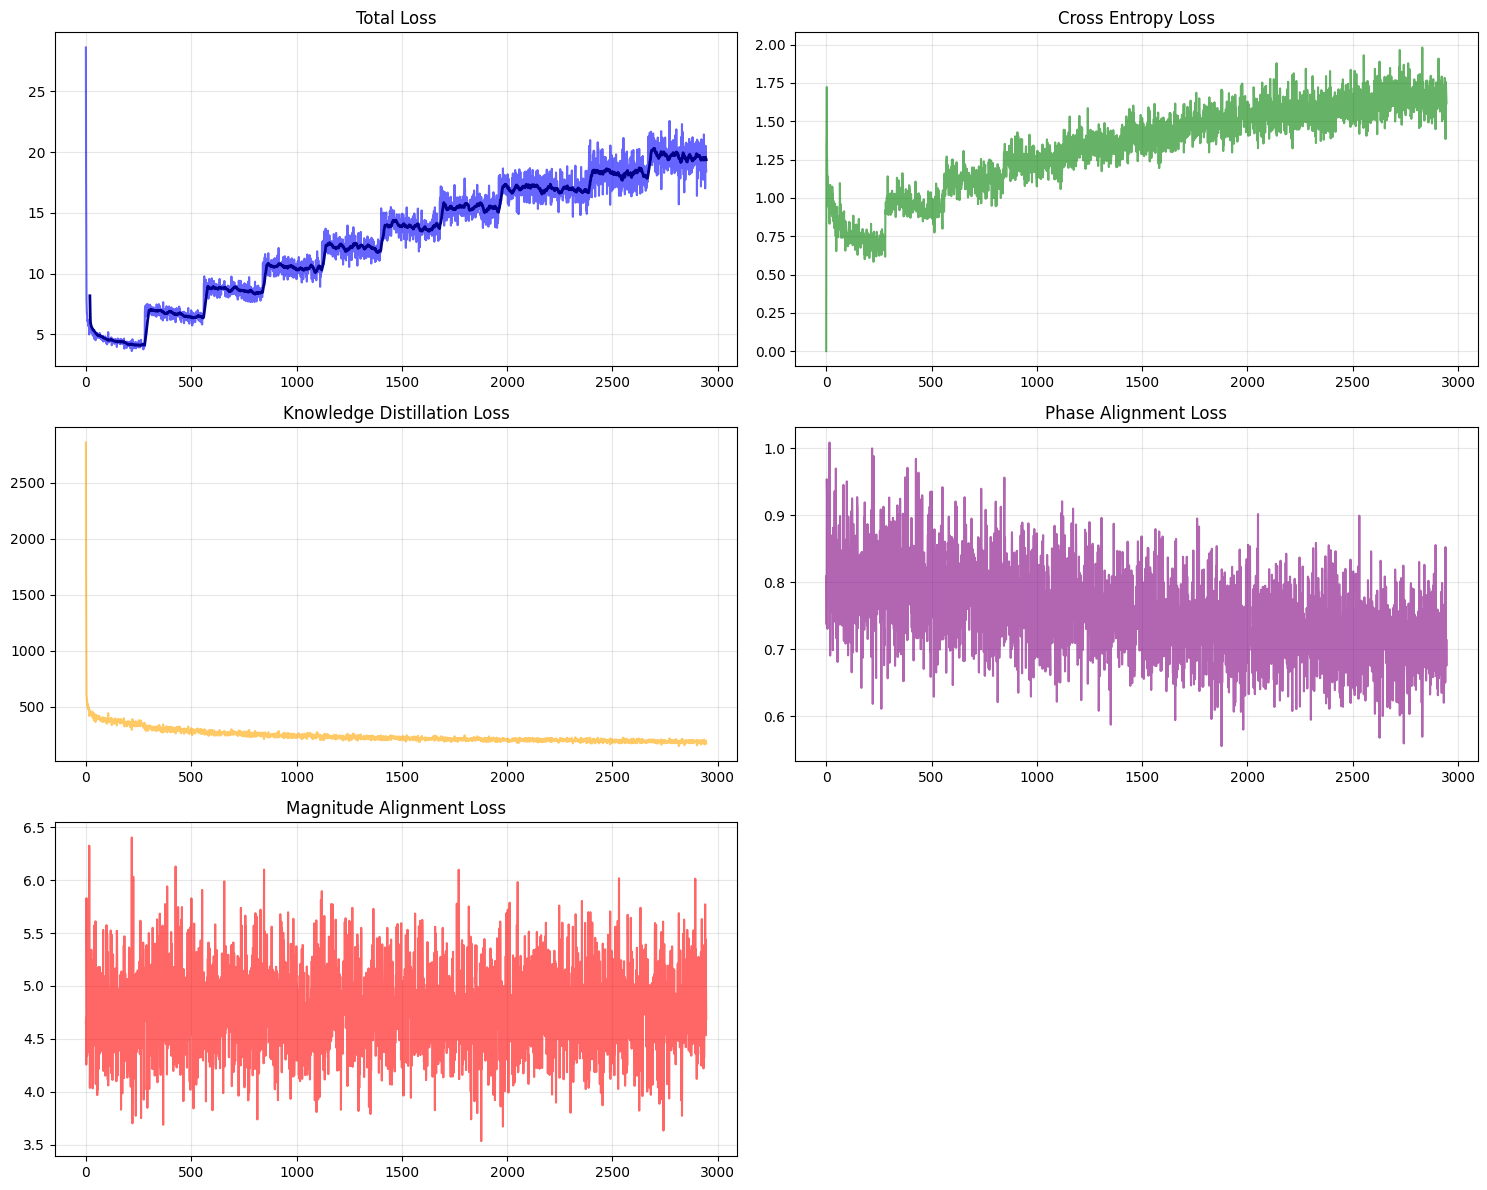

--- Stage 2 Statistics ---
          Epoch        Batch  Total_Loss        CE           KD     Phase  \
mean   5.623218  1361.344196   12.907760  1.323390   239.743908  0.754456   
min    1.000000     0.000000    3.623714  0.001305   146.969284  0.555175   
max   10.000000  2790.000000   28.596319  1.981037  2859.501465  1.008780   

           Mag  
mean  4.784329  
min   3.533627  
max   6.403389  


In [135]:
# Load Stage 2 Data
log_file_s2 = "../logs/training_metrics_stage2.csv"
if os.path.exists(log_file_s2):
    df_s2 = pd.read_csv(log_file_s2)

    fig, axes = plt.subplots(3, 2, figsize=(15, 12))
    axes = axes.flatten()

    # 1. Total Loss
    axes[0].plot(df_s2["Total_Loss"], label="Total Loss", color="blue", alpha=0.6)
    axes[0].plot(df_s2["Total_Loss"].rolling(20).mean(), color="darkblue", linewidth=2)
    axes[0].set_title("Total Loss")
    axes[0].grid(True, alpha=0.3)

    # 2. CE Loss
    axes[1].plot(df_s2["CE"], label="CE Loss", color="green", alpha=0.6)
    axes[1].set_title("Cross Entropy Loss")
    axes[1].grid(True, alpha=0.3)

    # 3. KD Loss
    axes[2].plot(df_s2["KD"], label="KD Loss", color="orange", alpha=0.6)
    axes[2].set_title("Knowledge Distillation Loss")
    axes[2].grid(True, alpha=0.3)

    # 4. Phase Loss
    axes[3].plot(df_s2["Phase"], label="Phase Loss", color="purple", alpha=0.6)
    axes[3].set_title("Phase Alignment Loss")
    axes[3].grid(True, alpha=0.3)

    # 5. Magnitude Loss
    axes[4].plot(df_s2["Mag"], label="Mag Loss", color="red", alpha=0.6)
    axes[4].set_title("Magnitude Alignment Loss")
    axes[4].grid(True, alpha=0.3)

    # Hide 6th plot
    axes[5].axis("off")

    plt.tight_layout()
    plt.show()

    # Detailed Statistics
    print("--- Stage 2 Statistics ---")
    print(df_s2.describe().iloc[[1, 3, 7]])  # Mean, Min, Max
else:
    print("Stage 2 log not found.")

## 5. Phase 2: Complete Loss Curve (Stage 1 + Stage 2)

This chart visualizes the entire training progression of Phase 2, combining Pre-training (Stage 1) and Semantic Distillation (Stage 2).


Loaded Stage 1: 579 steps
Loaded Stage 2: 2946 steps


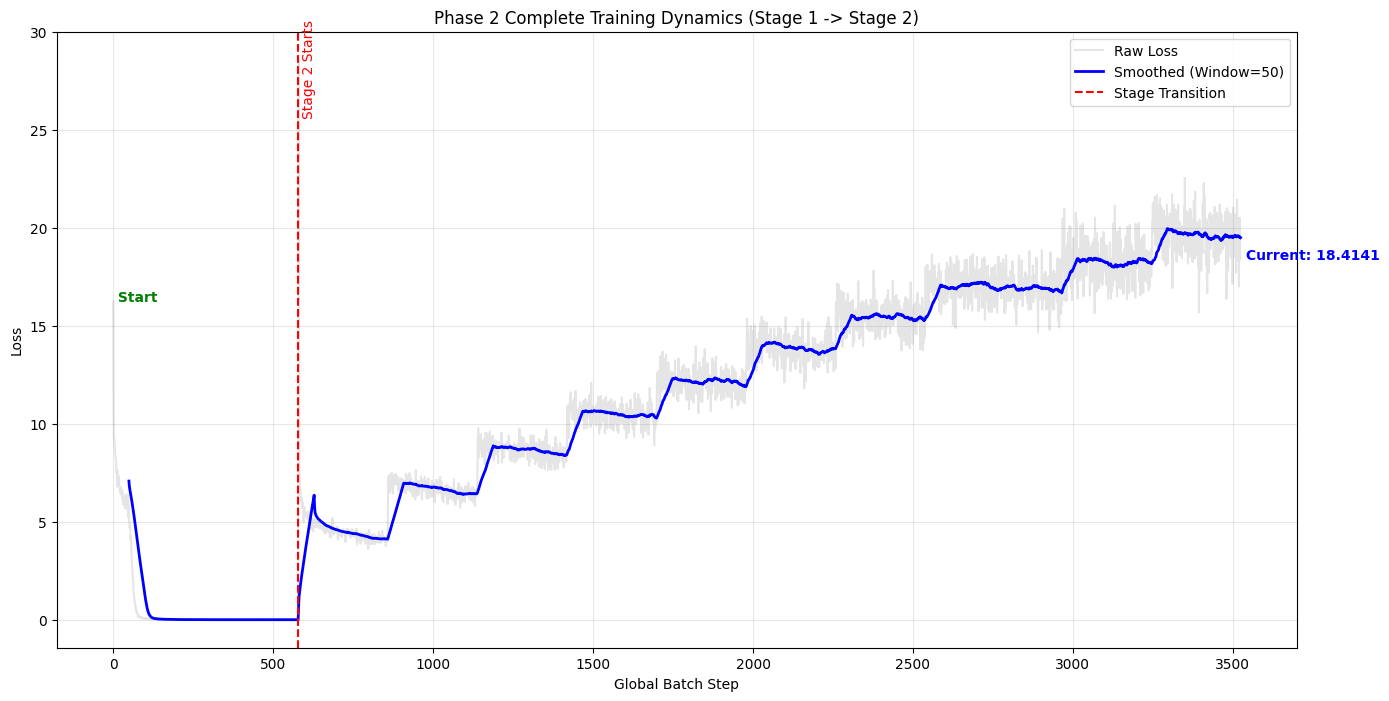

In [136]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Paths
stage1_log = "../logs/training_metrics_stage1.csv"
stage2_log = "../logs/training_metrics_stage2.csv"

loss_series = []
labels = []
stage_boundaries = []

# Load Stage 1
if os.path.exists(stage1_log):
    df1 = pd.read_csv(stage1_log)
    loss_series.extend(df1["Loss"].tolist())
    stage_boundaries.append(len(loss_series))
    print(f"Loaded Stage 1: {len(df1)} steps")

# Load Stage 2
if os.path.exists(stage2_log):
    df2 = pd.read_csv(stage2_log)
    loss_series.extend(df2["Total_Loss"].tolist())
    print(f"Loaded Stage 2: {len(df2)} steps")

# Plot
plt.figure(figsize=(16, 8))

# Raw Data
plt.plot(loss_series, label="Raw Loss", alpha=0.2, color="gray")

# Smoothed Data
series_pd = pd.Series(loss_series)
plt.plot(
    series_pd.rolling(50).mean(),
    label="Smoothed (Window=50)",
    color="blue",
    linewidth=2,
)

# Stage Markers
for boundary in stage_boundaries:
    plt.axvline(x=boundary, color="red", linestyle="--", label="Stage Transition")
    plt.text(
        boundary + 10,
        max(loss_series) * 0.9,
        "Stage 2 Starts",
        color="red",
        rotation=90,
    )

plt.title("Phase 2 Complete Training Dynamics (Stage 1 -> Stage 2)")
plt.xlabel("Global Batch Step")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)

# Annotations
if loss_series:
    plt.text(0, loss_series[0], " Start", color="green", fontweight="bold")
    plt.text(
        len(loss_series) - 1,
        loss_series[-1],
        f" Current: {loss_series[-1]:.4f}",
        color="blue",
        fontweight="bold",
    )

plt.show()

## 3. Phase 2 (Stage 1) Pre-training Analysis

Monitoring the initial pre-training loss on WikiText.


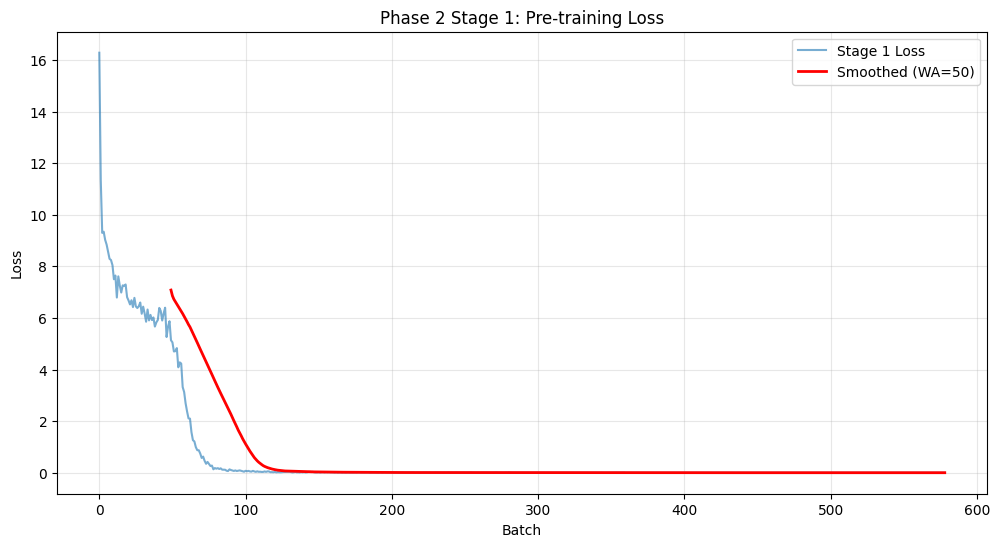

In [137]:
# Load Stage 1 Data
log_file_s1 = "../logs/training_metrics_stage1.csv"
if os.path.exists(log_file_s1):
    df_s1 = pd.read_csv(log_file_s1)
    plt.figure(figsize=(12, 6))
    plt.plot(df_s1["Loss"], label="Stage 1 Loss", alpha=0.6)
    plt.plot(
        df_s1["Loss"].rolling(50).mean(),
        label="Smoothed (WA=50)",
        color="red",
        linewidth=2,
    )
    plt.title("Phase 2 Stage 1: Pre-training Loss")
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("Stage 1 log not found.")

## 4. Phase 2 (Stage 2) Semantic Distillation Analysis

Monitoring the Semantic Distillation process comparing Student and Teacher.


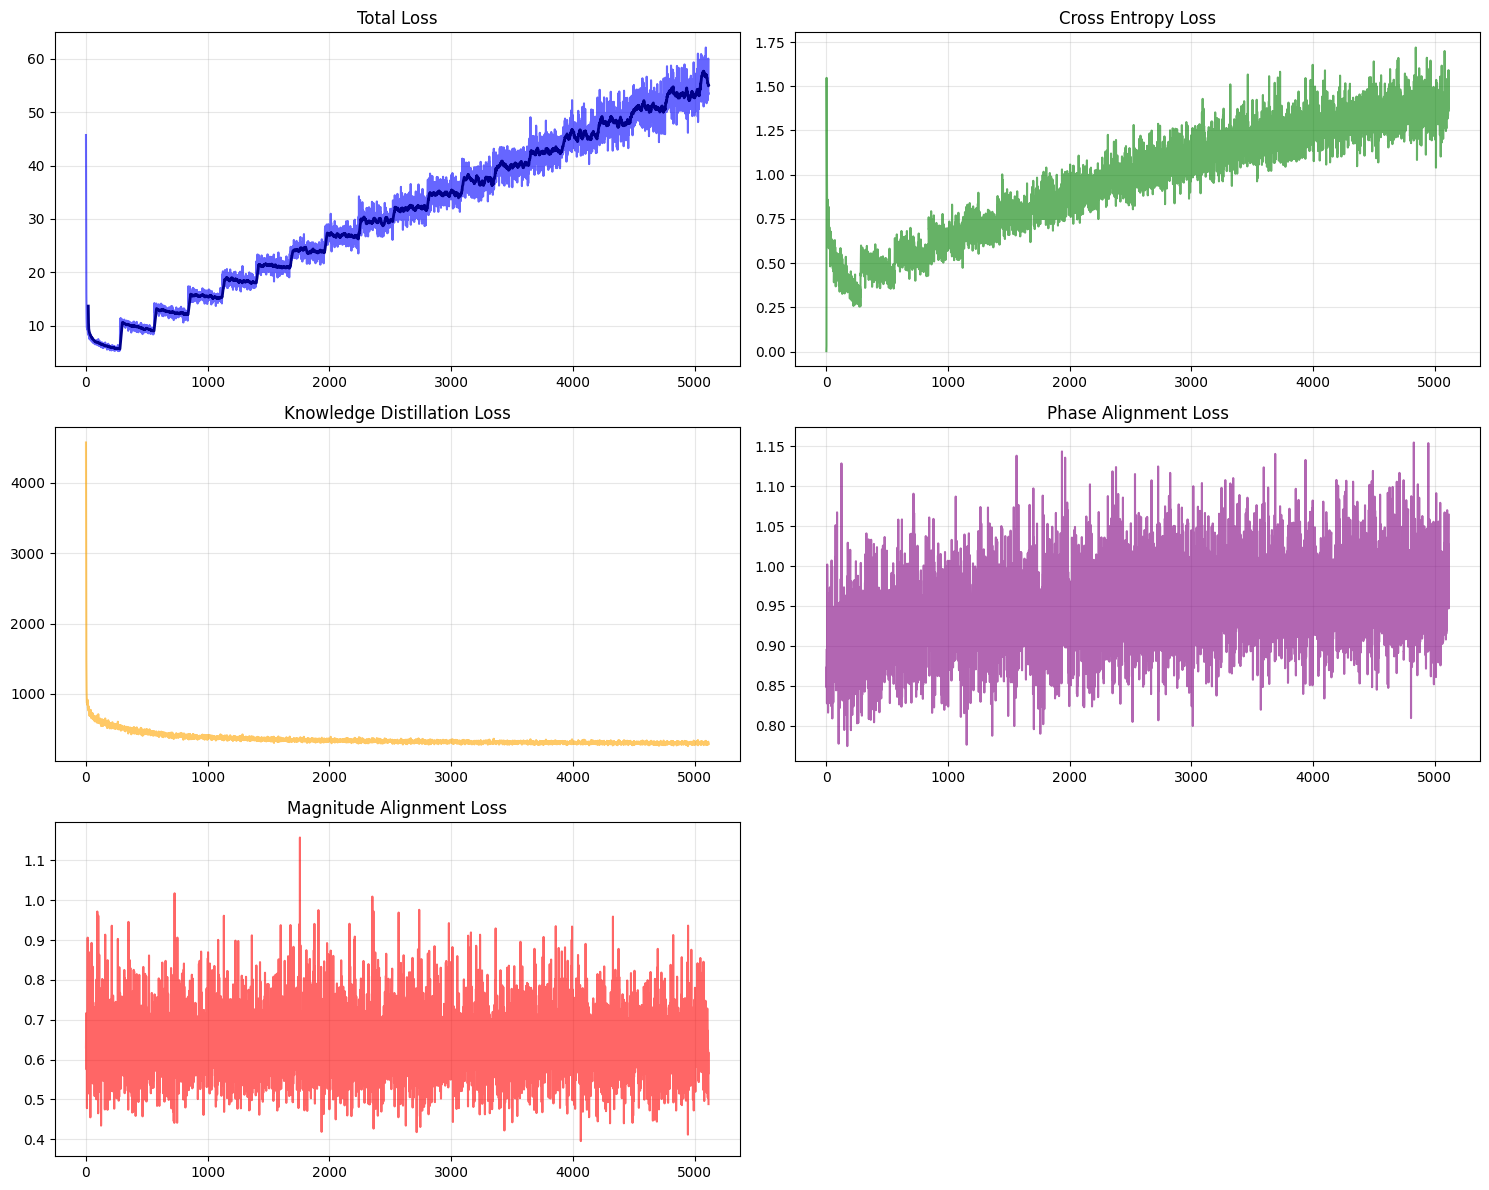

--- Stage 2 Statistics ---
          Epoch        Batch  Total_Loss        CE           KD     Phase  \
mean   9.641126  1379.847537   30.923021  0.968061   359.115494  0.950431   
min    1.000000     0.000000    5.278121  0.002374   260.279572  0.774213   
max   19.000000  2790.000000   62.085205  1.719229  4570.710938  1.154902   

           Mag  
mean  0.642144  
min   0.395351  
max   1.157388  


In [138]:
# Load Stage 2 Data
log_file_s2 = "../logs/training_metrics_stage2_v2.csv"
if os.path.exists(log_file_s2):
    df_s2 = pd.read_csv(log_file_s2)

    fig, axes = plt.subplots(3, 2, figsize=(15, 12))
    axes = axes.flatten()

    # 1. Total Loss
    axes[0].plot(df_s2["Total_Loss"], label="Total Loss", color="blue", alpha=0.6)
    axes[0].plot(df_s2["Total_Loss"].rolling(20).mean(), color="darkblue", linewidth=2)
    axes[0].set_title("Total Loss")
    axes[0].grid(True, alpha=0.3)

    # 2. CE Loss
    axes[1].plot(df_s2["CE"], label="CE Loss", color="green", alpha=0.6)
    axes[1].set_title("Cross Entropy Loss")
    axes[1].grid(True, alpha=0.3)

    # 3. KD Loss
    axes[2].plot(df_s2["KD"], label="KD Loss", color="orange", alpha=0.6)
    axes[2].set_title("Knowledge Distillation Loss")
    axes[2].grid(True, alpha=0.3)

    # 4. Phase Loss
    axes[3].plot(df_s2["Phase"], label="Phase Loss", color="purple", alpha=0.6)
    axes[3].set_title("Phase Alignment Loss")
    axes[3].grid(True, alpha=0.3)

    # 5. Magnitude Loss
    axes[4].plot(df_s2["Mag"], label="Mag Loss", color="red", alpha=0.6)
    axes[4].set_title("Magnitude Alignment Loss")
    axes[4].grid(True, alpha=0.3)

    # Hide 6th plot
    axes[5].axis("off")

    plt.tight_layout()
    plt.show()

    # Detailed Statistics
    print("--- Stage 2 Statistics ---")
    print(df_s2.describe().iloc[[1, 3, 7]])  # Mean, Min, Max
else:
    print("Stage 2 log not found.")

## 5. Phase 2: Complete Loss Curve (Stage 1 + Stage 2)

This chart visualizes the entire training progression of Phase 2, combining Pre-training (Stage 1) and Semantic Distillation (Stage 2).


Loaded Stage 1: 579 steps
Loaded Stage 2: 5116 steps


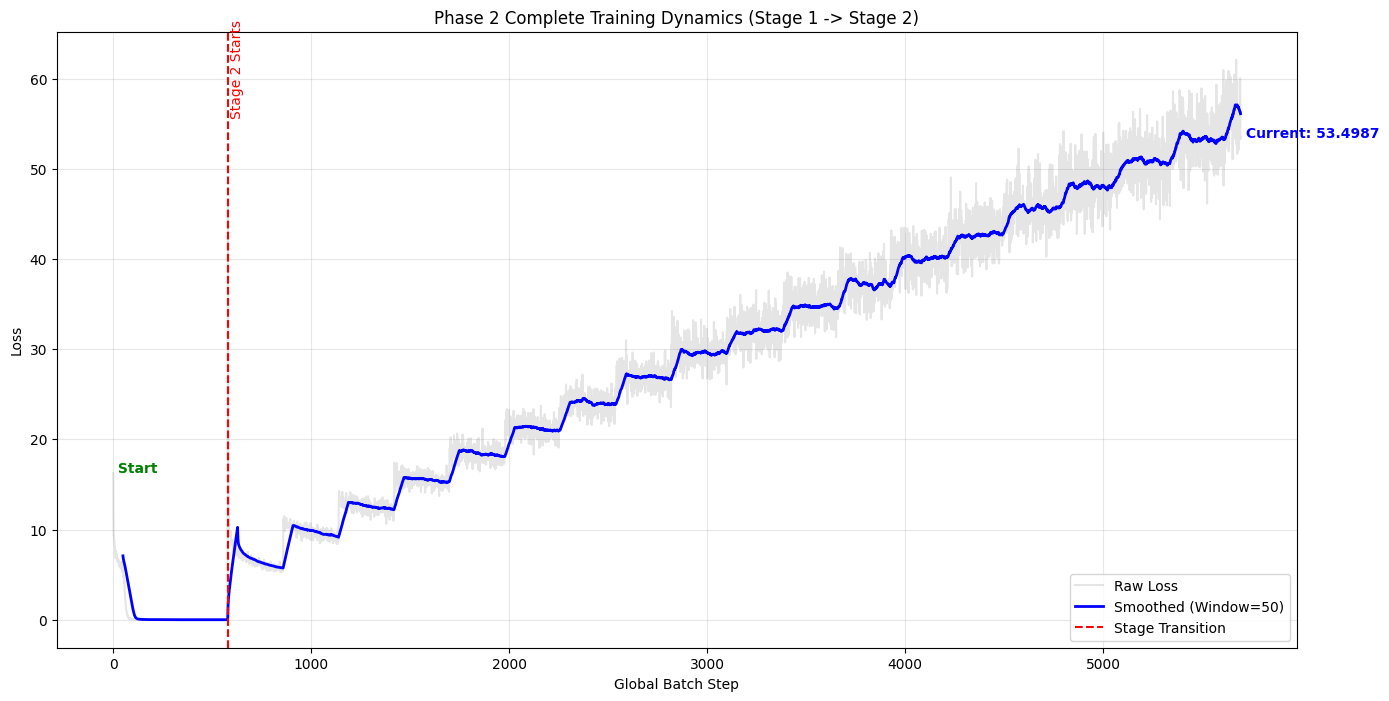

In [139]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Paths
stage1_log = "../logs/training_metrics_stage1.csv"
stage2_log = "../logs/training_metrics_stage2_v2.csv"

loss_series = []
labels = []
stage_boundaries = []

# Load Stage 1
if os.path.exists(stage1_log):
    df1 = pd.read_csv(stage1_log)
    loss_series.extend(df1["Loss"].tolist())
    stage_boundaries.append(len(loss_series))
    print(f"Loaded Stage 1: {len(df1)} steps")

# Load Stage 2
if os.path.exists(stage2_log):
    df2 = pd.read_csv(stage2_log)
    loss_series.extend(df2["Total_Loss"].tolist())
    print(f"Loaded Stage 2: {len(df2)} steps")

# Plot
plt.figure(figsize=(16, 8))

# Raw Data
plt.plot(loss_series, label="Raw Loss", alpha=0.2, color="gray")

# Smoothed Data
series_pd = pd.Series(loss_series)
plt.plot(
    series_pd.rolling(50).mean(),
    label="Smoothed (Window=50)",
    color="blue",
    linewidth=2,
)

# Stage Markers
for boundary in stage_boundaries:
    plt.axvline(x=boundary, color="red", linestyle="--", label="Stage Transition")
    plt.text(
        boundary + 10,
        max(loss_series) * 0.9,
        "Stage 2 Starts",
        color="red",
        rotation=90,
    )

plt.title("Phase 2 Complete Training Dynamics (Stage 1 -> Stage 2)")
plt.xlabel("Global Batch Step")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)

# Annotations
if loss_series:
    plt.text(0, loss_series[0], " Start", color="green", fontweight="bold")
    plt.text(
        len(loss_series) - 1,
        loss_series[-1],
        f" Current: {loss_series[-1]:.4f}",
        color="blue",
        fontweight="bold",
    )

plt.show()

## 5. Phase 2: Complete Training Dynamics (Stage 1 + Stage 2)

This comprehensive chart visualizes the transition from Pre-training (Stage 1) to Semantic Distillation (Stage 2).

- **Left Axis (Blue/Green):** Tracks the **Total Loss** and **Cross-Entropy (CE) Loss**. Note how CE improves consistently across stages.
- **Right Axis (Orange):** Tracks the **Knowledge Distillation (KD) Loss**. This appears only in Stage 2, representing the effort to mimic the Teacher model's probability distribution.


Loaded Stage 1: 579 steps
Loaded Stage 2: 5116 steps


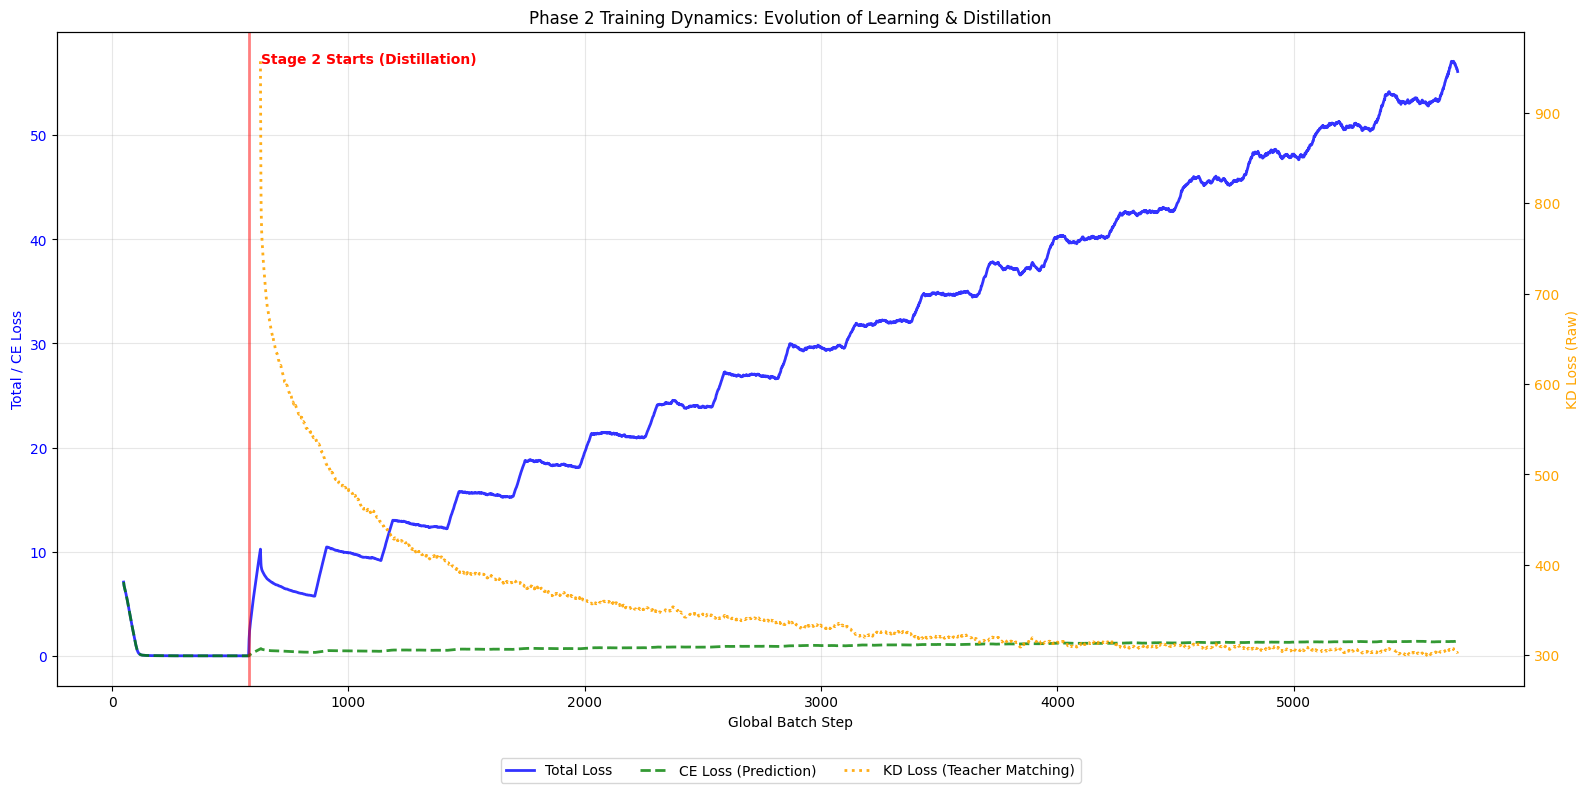

In [140]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Paths
stage1_log = "../logs/training_metrics_stage1.csv"
stage2_log = "../logs/training_metrics_stage2_v2.csv"

# Data Containers
total_loss = []
ce_loss = []
kd_loss = []
stage_boundaries = []

# Load Stage 1
if os.path.exists(stage1_log):
    df1 = pd.read_csv(stage1_log)
    # In Stage 1, Total Loss is just CE Loss (Basic Pre-training)
    total_loss.extend(df1["Loss"].tolist())
    ce_loss.extend(df1["Loss"].tolist())
    kd_loss.extend([None] * len(df1))  # No KD in Stage 1
    stage_boundaries.append(len(total_loss))
    print(f"Loaded Stage 1: {len(df1)} steps")

# Load Stage 2
if os.path.exists(stage2_log):
    df2 = pd.read_csv(stage2_log)
    total_loss.extend(df2["Total_Loss"].tolist())
    ce_loss.extend(df2["CE"].tolist())
    kd_loss.extend(df2["KD"].tolist())
    print(f"Loaded Stage 2: {len(df2)} steps")

# Smoothing
window = 50
total_smooth = pd.Series(total_loss).rolling(window).mean()
ce_smooth = pd.Series(ce_loss).rolling(window).mean()
kd_smooth = pd.Series(kd_loss).rolling(window).mean()

# Plotting
fig, ax1 = plt.subplots(figsize=(16, 8))

# Axis 1: Total Loss & CE (Left Scale)
ax1.plot(total_smooth, label="Total Loss", color="blue", linewidth=2, alpha=0.8)
ax1.plot(
    ce_smooth,
    label="CE Loss (Prediction)",
    color="green",
    linewidth=2,
    linestyle="--",
    alpha=0.8,
)
ax1.set_xlabel("Global Batch Step")
ax1.set_ylabel("Total / CE Loss", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")
ax1.grid(True, alpha=0.3)

# Axis 2: KD Loss (Right Scale)
ax2 = ax1.twinx()
ax2.plot(
    kd_smooth,
    label="KD Loss (Teacher Matching)",
    color="orange",
    linewidth=2,
    linestyle=":",
    alpha=0.9,
)
ax2.set_ylabel("KD Loss (Raw)", color="orange")
ax2.tick_params(axis="y", labelcolor="orange")

# Stage Markers
for boundary in stage_boundaries:
    ax1.axvline(x=boundary, color="red", linestyle="-", linewidth=2, alpha=0.5)
    ax1.text(
        boundary + 50,
        ax1.get_ylim()[1] * 0.95,
        "Stage 2 Starts (Distillation)",
        color="red",
        fontweight="bold",
    )

# Title & Legend
plt.title("Phase 2 Training Dynamics: Evolution of Learning & Distillation")
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(
    lines1 + lines2,
    labels1 + labels2,
    loc="upper center",
    bbox_to_anchor=(0.5, -0.1),
    ncol=3,
)

plt.tight_layout()
plt.show()

## 3. Phase 2 (Stage 1) Pre-training Analysis

Monitoring the initial pre-training loss on WikiText.


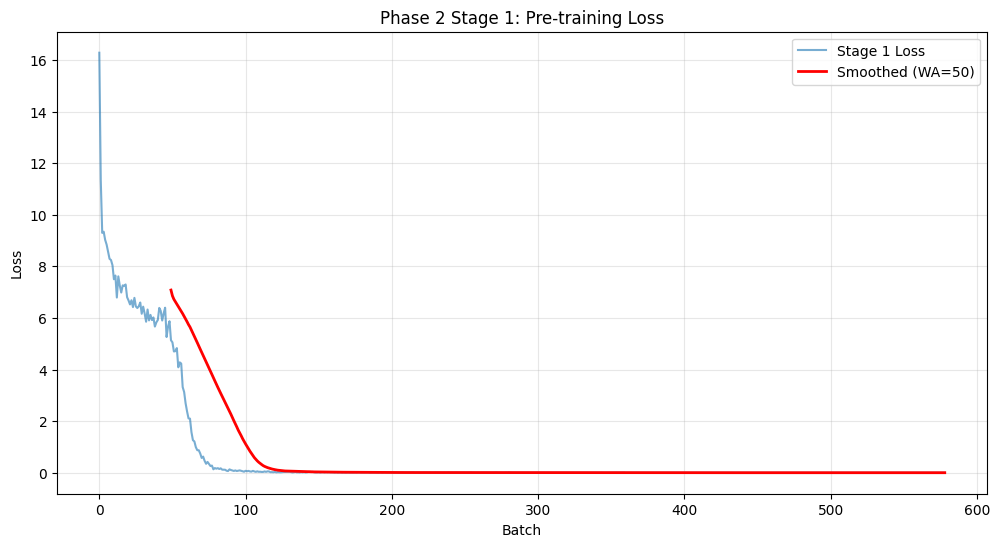

In [141]:
# Load Stage 1 Data
log_file_s1 = "../logs/training_metrics_stage1.csv"
if os.path.exists(log_file_s1):
    df_s1 = pd.read_csv(log_file_s1)
    plt.figure(figsize=(12, 6))
    plt.plot(df_s1["Loss"], label="Stage 1 Loss", alpha=0.6)
    plt.plot(
        df_s1["Loss"].rolling(50).mean(),
        label="Smoothed (WA=50)",
        color="red",
        linewidth=2,
    )
    plt.title("Phase 2 Stage 1: Pre-training Loss")
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("Stage 1 log not found.")

## 4. Phase 2 (Stage 2) Semantic Distillation Analysis

Monitoring the Semantic Distillation process comparing Student and Teacher.


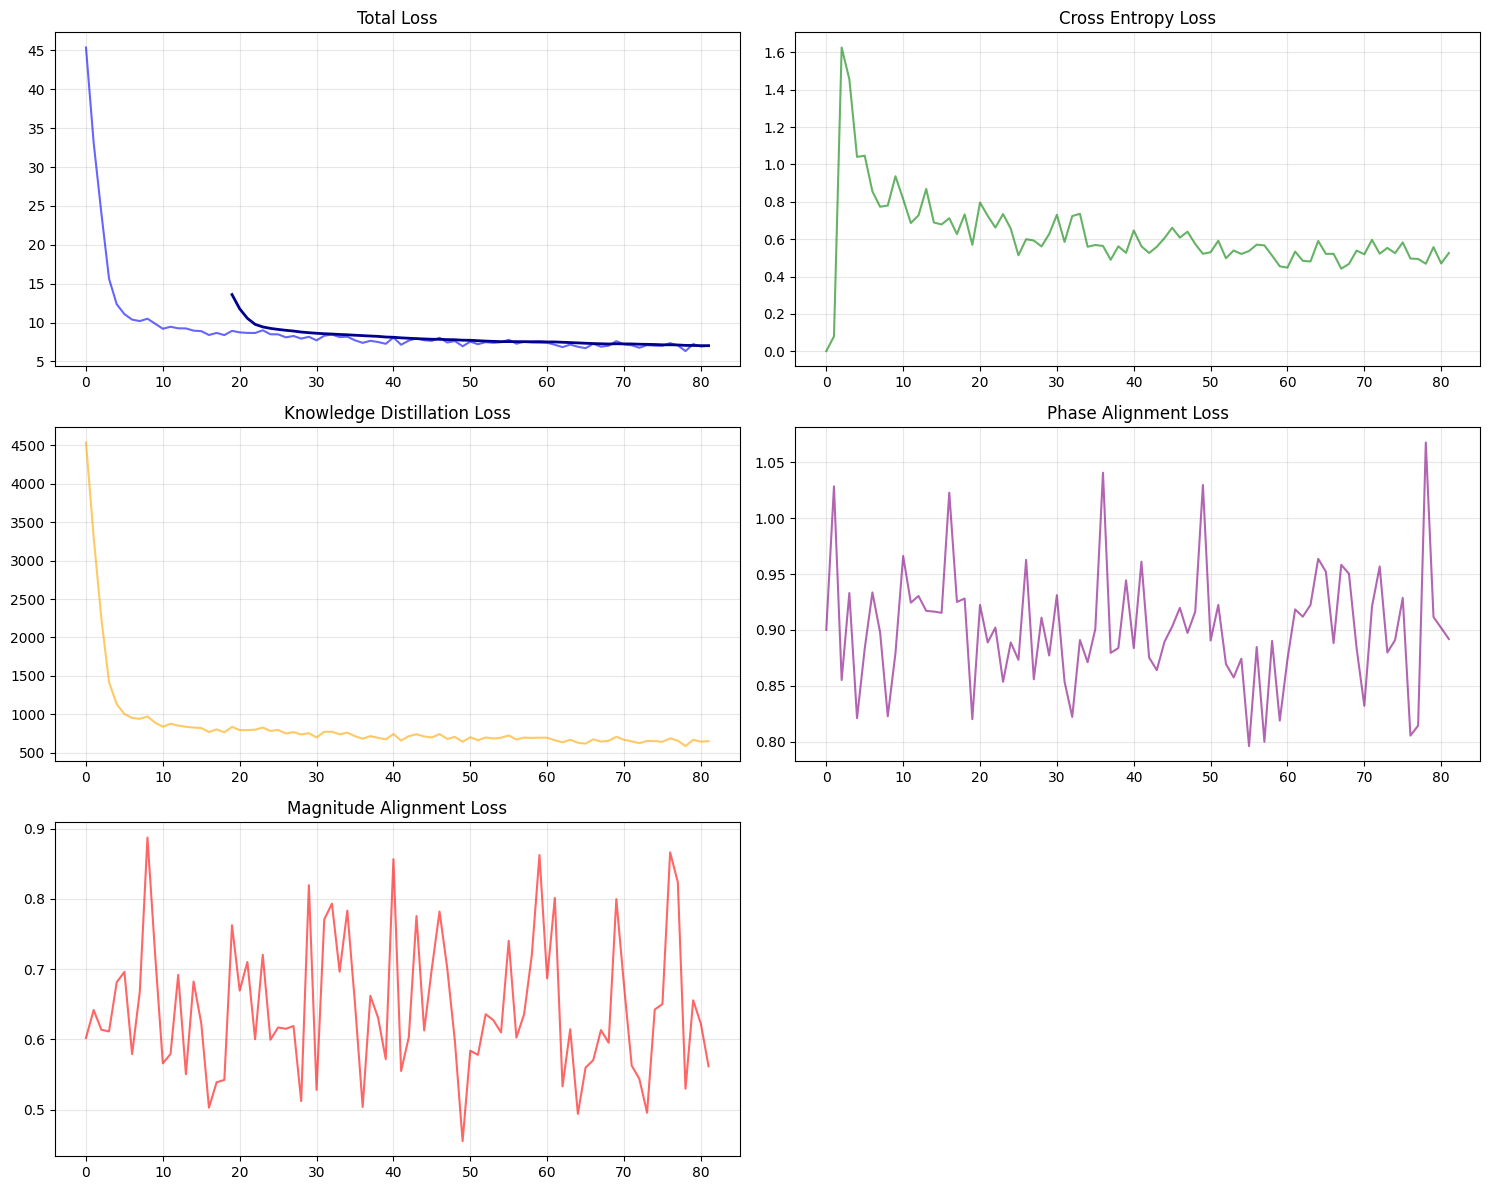

--- Stage 2 Statistics ---
      Epoch  Batch  Total_Loss        CE           KD     Phase       Mag
mean    1.0  405.0    9.032579  0.619365   841.321362  0.901691  0.645819
min     1.0    0.0    6.329560  0.000641   586.115051  0.795987  0.455467
max     1.0  810.0   45.364948  1.626480  4536.430664  1.067694  0.887293


In [ ]:
# Load Stage 2 Data
log_file_s2 = "../logs/training_metrics_stage2_v3.csv"
if os.path.exists(log_file_s2):
    df_s2 = pd.read_csv(log_file_s2)

    fig, axes = plt.subplots(3, 2, figsize=(15, 12))
    axes = axes.flatten()

    # 1. Total Loss
    axes[0].plot(df_s2["Total_Loss"], label="Total Loss", color="blue", alpha=0.6)
    axes[0].plot(df_s2["Total_Loss"].rolling(20).mean(), color="darkblue", linewidth=2)
    axes[0].set_title("Total Loss")
    axes[0].grid(True, alpha=0.3)

    # 2. CE Loss
    axes[1].plot(df_s2["CE"], label="CE Loss", color="green", alpha=0.6)
    axes[1].set_title("Cross Entropy Loss")
    axes[1].grid(True, alpha=0.3)

    # 3. KD Loss
    axes[2].plot(df_s2["KD"], label="KD Loss", color="orange", alpha=0.6)
    axes[2].set_title("Knowledge Distillation Loss")
    axes[2].grid(True, alpha=0.3)

    # 4. Phase Loss
    axes[3].plot(df_s2["Phase"], label="Phase Loss", color="purple", alpha=0.6)
    axes[3].set_title("Phase Alignment Loss")
    axes[3].grid(True, alpha=0.3)

    # 5. Magnitude Loss
    axes[4].plot(df_s2["Mag"], label="Mag Loss", color="red", alpha=0.6)
    axes[4].set_title("Magnitude Alignment Loss")
    axes[4].grid(True, alpha=0.3)

    # Hide 6th plot
    axes[5].axis("off")

    plt.tight_layout()
    plt.show()

    # Detailed Statistics
    print("--- Stage 2 Statistics ---")
    print(df_s2.describe().iloc[[1, 3, 7]])  # Mean, Min, Max
else:
    print("Stage 2 log not found.")

## 5. Phase 2: Complete Training Dynamics (Stage 1 + Stage 2)

This comprehensive chart visualizes the transition from Pre-training (Stage 1) to Semantic Distillation (Stage 2).

- **Left Axis (Blue/Green):** Tracks the **Total Loss** and **Cross-Entropy (CE) Loss**. Note how CE improves consistently across stages.
- **Right Axis (Orange):** Tracks the **Knowledge Distillation (KD) Loss**. This appears only in Stage 2, representing the effort to mimic the Teacher model's probability distribution.


Loaded Stage 1: 579 steps
Loaded Stage 2: 774 steps


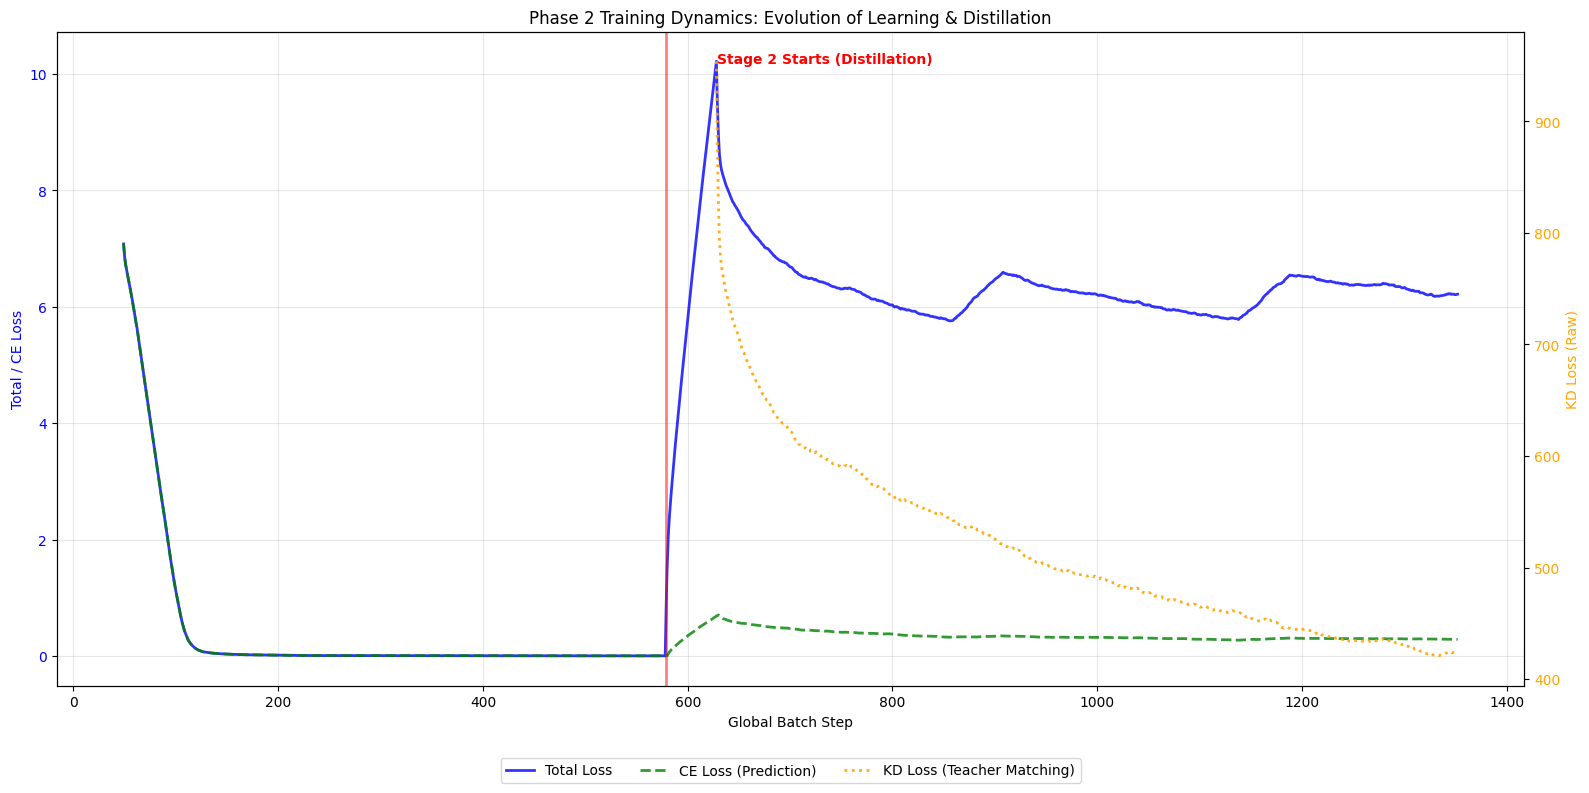

In [148]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Paths
stage1_log = "../logs/training_metrics_stage1.csv"
stage2_log = "../logs/training_metrics_stage2_v3.csv"

# Data Containers
total_loss = []
ce_loss = []
kd_loss = []
stage_boundaries = []

# Load Stage 1
if os.path.exists(stage1_log):
    df1 = pd.read_csv(stage1_log)
    # In Stage 1, Total Loss is just CE Loss (Basic Pre-training)
    total_loss.extend(df1["Loss"].tolist())
    ce_loss.extend(df1["Loss"].tolist())
    kd_loss.extend([None] * len(df1))  # No KD in Stage 1
    stage_boundaries.append(len(total_loss))
    print(f"Loaded Stage 1: {len(df1)} steps")

# Load Stage 2
if os.path.exists(stage2_log):
    df2 = pd.read_csv(stage2_log)
    total_loss.extend(df2["Total_Loss"].tolist())
    ce_loss.extend(df2["CE"].tolist())
    kd_loss.extend(df2["KD"].tolist())
    print(f"Loaded Stage 2: {len(df2)} steps")

# Smoothing
window = 50
total_smooth = pd.Series(total_loss).rolling(window).mean()
ce_smooth = pd.Series(ce_loss).rolling(window).mean()
kd_smooth = pd.Series(kd_loss).rolling(window).mean()

# Plotting
fig, ax1 = plt.subplots(figsize=(16, 8))

# Axis 1: Total Loss & CE (Left Scale)
ax1.plot(total_smooth, label="Total Loss", color="blue", linewidth=2, alpha=0.8)
ax1.plot(
    ce_smooth,
    label="CE Loss (Prediction)",
    color="green",
    linewidth=2,
    linestyle="--",
    alpha=0.8,
)
ax1.set_xlabel("Global Batch Step")
ax1.set_ylabel("Total / CE Loss", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")
ax1.grid(True, alpha=0.3)

# Axis 2: KD Loss (Right Scale)
ax2 = ax1.twinx()
ax2.plot(
    kd_smooth,
    label="KD Loss (Teacher Matching)",
    color="orange",
    linewidth=2,
    linestyle=":",
    alpha=0.9,
)
ax2.set_ylabel("KD Loss (Raw)", color="orange")
ax2.tick_params(axis="y", labelcolor="orange")

# Stage Markers
for boundary in stage_boundaries:
    ax1.axvline(x=boundary, color="red", linestyle="-", linewidth=2, alpha=0.5)
    ax1.text(
        boundary + 50,
        ax1.get_ylim()[1] * 0.95,
        "Stage 2 Starts (Distillation)",
        color="red",
        fontweight="bold",
    )

# Title & Legend
plt.title("Phase 2 Training Dynamics: Evolution of Learning & Distillation")
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(
    lines1 + lines2,
    labels1 + labels2,
    loc="upper center",
    bbox_to_anchor=(0.5, -0.1),
    ncol=3,
)

plt.tight_layout()
plt.show()

## 6. Phase 2 (Stage 1.5): Mixed Pre-training (WikiText + Alpaca)

Training on a combined dataset of General Knowledge (WikiText) and Instructions (Alpaca) to build a robust base before distillation.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Load Mixed Stage 1 Data
log_file_mixed = "../logs/training_metrics_stage1_mixed.csv"
if os.path.exists(log_file_mixed):
    df_mixed = pd.read_csv(log_file_mixed)
    plt.figure(figsize=(12, 6))
    plt.plot(df_mixed["Loss"], label="Mixed Stage 1 Loss", alpha=0.4, color="gray")
    plt.plot(df_mixed["Loss"].rolling(50).mean(), label="Smoothed (WA=50)", color="purple", linewidth=2)
    plt.title("Phase 2 Stage 1.5: Mixed Pre-training Loss")
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("Mixed Stage 1 log not found.")